In [50]:
import pandas as pd
import numpy as np
import pickle
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import joblib
import matplotlib.pyplot as plt   #for data visualization and graphical plotting
from matplotlib import style      #for styling the plot
style.use("ggplot")

import nltk
from nltk.util import pr
from nltk.tokenize import word_tokenize      #to divide strings into lists of substrings
from nltk.stem import WordNetLemmatizer      #to link words with similar meanings to one word.
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords            #to filterout useless data
stopword = set(stopwords.words('english'))

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing the Dataset

In [51]:
data = pd.read_csv("/content/labeled_data.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Data Visualization

Adding  a new column to this dataset as labels which will contain the values as:

1. Hate Speech
2. Offensive Language
3. No Hate and Offensive

In [52]:
data["labels"] = data["class"].map({0: "Hate",
                                    1: "Offensive",
                                    2: "Normal"})
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,labels
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Normal
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive


Now we only select the tweet and labels columns for the rest of the task of training a hate speech detection model:

In [53]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,Normal
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive


## Data Preprocessing

In [54]:
def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\@w+|\#",'',text)
    text = re.sub(r"[^\w\s]",'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tweet_tokens = word_tokenize(text)
    filtered_tweets=[w for w in tweet_tokens if not w in stopword] #removing stopwords
    return " ".join(filtered_tweets)

In [55]:
#applying pre-processing to text data
data.tweet=data['tweet'].apply(clean)          ###########################################################

In [56]:
# removing duplicate data
tweetData = data.drop_duplicates("tweet")

In [57]:
lemmatizer=WordNetLemmatizer()
def lemmatizing(data):
    tweet=[lemmatizer.lemmatize(data)]
    return tweet

In [58]:
#lemmatizing the processed data
tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))###############################################
tweetData.head()

<ipython-input-58-9f8ecaf585c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetData['tweet']=tweetData['tweet'].apply(lambda x: lemmatizing(x))###############################################


,tweet,labels
0,[rt mayasolovely woman shouldnt complain clean...,Normal
1,[rt boy dats coldtyga dwn bad cuffin dat hoe p...,Offensive
2,[rt urkindofbrand dawg rt ever fuck bitch star...,Offensive
3,[rt cganderson vivabased look like tranny],Offensive
4,[rt shenikaroberts shit hear might true might ...,Offensive


In [59]:
# to see distribution of labels
tweetData['labels'].value_counts()

Offensive    18984
Normal        4113
Hate          1409
Name: labels, dtype: int64

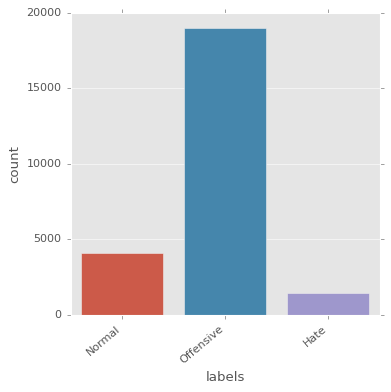

In [60]:
# to visualize the data using a count plot
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='labels', data=tweetData)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of sentiments')

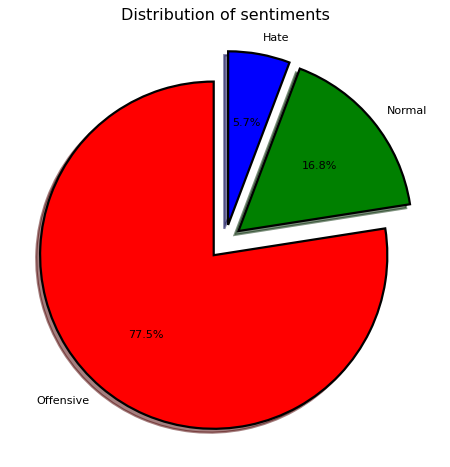

In [61]:
# visualizing data using piechart
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue')
wp = {'linewidth':2, "edgecolor":'black'}
tags = tweetData['labels'].value_counts()
explode=(0.1,0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='')
plt.title("Distribution of sentiments")

**TF - IDF: Term frequence - Inverse Document Frequency**

    TF-IDF = TF(t,d) x IDF(t),
    where TF(t,d) = number of times term "t" appears in a document "d".
          IDF(t) = inverse document frequency of the term t

The TF-IDF vectorizer converts a collection of raw documents into a matrix of TF-IDF features.

* **Bigram model**: provides probability of the next word given the past two words.
* **Trigram model**: provides probability of the next word based on past three words.
* **N-gram model**: provides probability based on past N-words.

In [62]:
tweetData['tweet'] = tweetData['tweet'].apply(lambda x: ' '.join(map(str, x)))

<ipython-input-62-a71673c8bcc2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweetData['tweet'] = tweetData['tweet'].apply(lambda x: ' '.join(map(str, x)))


### TF-IDF Trigram Model

In [63]:
#creating a trigram language model
vect=TfidfVectorizer(ngram_range=(1,3)).fit(tweetData['tweet'])

In [64]:
feature_names=vect.get_feature_names_out()
print("Number of features: {}\n", format(len(feature_names)))
print("First 200 features: \n", format(feature_names[:200]))

Number of features: {}
 310426
First 200 features: 
 ['aa' 'aa classes' 'aa classes bc' 'aa lol' 'aa lol gduenez' 'aaaaaaaaand'
 'aaaaaaaaand begins' 'aaaaaaaaand begins rt' 'aaahhhhh'
 'aaahhhhh internet' 'aaahhhhh internet died' 'aahahah' 'aahahah fuck'
 'aahahah fuck watches' 'aaliyah' 'aaliyah curving' 'aaliyah curving low'
 'aaliyahhhm' 'aaliyahhhm knowww' 'aaliyahhhm knowww righttt'
 'aaliyahhlovee' 'aaliyahhlovee yu' 'aaliyahhlovee yu betta'
 'aamaadmiparty' 'aamaadmiparty mix' 'aamaadmiparty mix retards' 'aampt'
 'aampt ackin' 'aampt ackin like' 'aamu' 'aan' 'aan de' 'aan de stok'
 'aanderlusting' 'aanderlusting id' 'aanderlusting id chink' 'aap'
 'aap maoists' 'aap maoists terroristscongies' 'aap rocky' 'aap rocky via'
 'aap shortsaid' 'aap shortsaid know' 'aaron' 'aaron hernandez'
 'aaron hernandez went' 'aaron hernandezs' 'aaron hernandezs girlfriend'
 'aaron weak' 'aaron weak last' 'aaroncarter' 'aaroncarter push'
 'aaroncarter push wall' 'aaronkeplin' 'aaronkeplin shut'
 '

## Split Dataset

In [65]:
tweetData[tweetData['labels'] == 'Hate'].value_counts()

tweet                                                                                   labels
faggot                                                                                  Hate      2
aaaaaaaaand begins rt rileydakafka fucking niggers thats kentucky ever                  Hate      1
rt go take trash darkskin nigga stole damn garbage                                      Hate      1
rt hate hoe ass people                                                                  Hate      1
rt hate hoe already shit cracks                                                         Hate      1
                                                                                                 ..
iamken fuck brett farve redneck ass stuckup dont give damn lol campus acting like shit  Hate      1
huntermoore nigger                                                                      Hate      1
huntermoore happy cuz woke white nigger                                                 Hate      1
hungl

In [66]:
hate_speech_data = tweetData[tweetData['labels'] == 'Hate']
non_hate_speech_data = tweetData[tweetData['labels'] != 'Hate'].sample(n=1408, random_state=42)
non_hate_speech_data['labels'] = 'No Hate'
new_hate_data = pd.concat([hate_speech_data, non_hate_speech_data])
new_hate_data = new_hate_data.sample(frac=1, random_state=42).reset_index(drop=True)
new_hate_data

,tweet,labels
0,aint shit without scale bitch live bag life,No Hate
1,ogs love see yung nicca come,No Hate
2,rt ford ford fancy name fag mobile,No Hate
3,gay ass nigga bitch thought thought,Hate
4,rt tooracist black guy school asked colored pr...,Hate
...,...,...
2812,rt blackhilton yall hoes thighs thick cant eve...,No Hate
2813,rt tanktopshotta real nigga gone teach bitch g...,Hate
2814,rt missvain lmfaooooo gtrt lmaoo thats u got r...,Hate
2815,ugly fucking nigger baby thought gorilla,Hate


In [67]:
#separating the data into x and y to build the model
X = new_hate_data['tweet']
Y = new_hate_data['labels']
X = vect.transform(X) #transforming the x data

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [69]:
#printing the size of training and testing data
print("Size of X_train", (X_train.shape))
print("Size of Y_train", (Y_train.shape))
print("Size of X_test", (X_test.shape))
print("Size of Y_test", (Y_test.shape))

Size of X_train (2253, 310426)
Size of Y_train (2253,)
Size of X_test (564, 310426)
Size of Y_test (564,)


## Model Training & Testing

### 1. Logistic Regression

In [70]:
#for training the data on logistic regression model
logreg_hate = LogisticRegression()
logreg_hate.fit(X_train, Y_train) #loading x_train and y_train data on model
logreg_hate_predict = logreg_hate.predict(X_test) #predicting the value for test data
logreg_hate_acc = accuracy_score(logreg_hate_predict, Y_test)

In [71]:
print("Test accuracy: {:.2f}%".format(logreg_hate_acc*100)) #printing accuracy of the model

Test accuracy: 75.53%


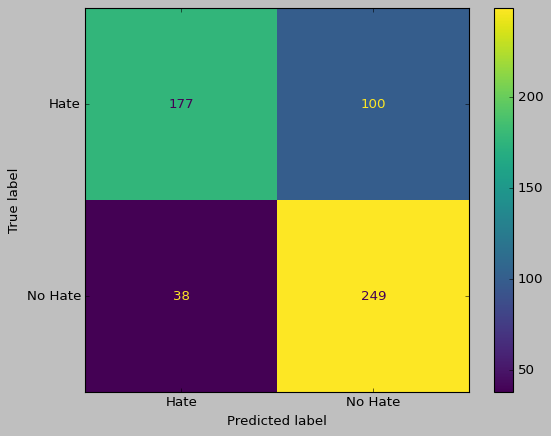

In [72]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, logreg_hate_predict, labels=logreg_hate.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_hate.classes_)
disp.plot()

In [73]:
tweetData[tweetData['labels'] == 'Normal'].value_counts()

tweet                                                                                                           labels
                                                                                                                Normal    1
rt joleendoreen kik group called party line old charlie barber always hogging calls                             Normal    1
rt kickin trash cans golf cart yeeyee jbilinovich                                                               Normal    1
rt kickman giants pitiful jetspitiful mets pitiful yankeespitiful nets pitiful knickspitiful ny sports pitiful  Normal    1
rt kid listened nas showed new perspective coming ghetto like pimp c                                            Normal    1
                                                                                                                         ..
jstarrtweets took harder rivera retired im yankee fan lot love respect em especially core                       Normal    1
judgmentalnye

In [74]:
normal_data = tweetData[tweetData['labels'] == 'Normal']
not_normal_data = tweetData[tweetData['labels'] != 'Normal'].sample(n=4113, random_state=42)
not_normal_data['labels'] = 'Not Normal'
new_normal_data = pd.concat([normal_data, not_normal_data])
new_normal_data = new_normal_data.sample(frac=1, random_state=42).reset_index(drop=True)
new_normal_data

,tweet,labels
0,white trash watch football,Not Normal
1,rt ipreferariplz every time black woman says o...,Not Normal
2,u eat fried eggs leave yolk entirely yellow ur...,Normal
3,rt andymilonakis give bitches amex gon na act ...,Not Normal
4,rt melodicthunder nah trash rt ishaboibrandon ...,Normal
...,...,...
8221,uptownraised shame mama didnt teach call women...,Not Normal
8222,yes functioning tho rt blaaksuedepumps retarded,Not Normal
8223,marilyn monroe set standard hoes achieve society,Not Normal
8224,yankees probably time put twitter feed bed nyy,Normal


In [75]:
#separating the data into x and y to build the model
X = new_normal_data['tweet']
Y = new_normal_data['labels']
X = vect.transform(X) #transforming the x data

In [76]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [77]:
#for training the data on logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train) #loading x_train and y_train data on model
logreg_predict = logreg.predict(X_test) #predicting the value for test data
logreg_acc = accuracy_score(logreg_predict, Y_test)

In [78]:
print("Test accuracy: {:.2f}%".format(logreg_acc*100)) #printing accuracy of the model

Test accuracy: 92.83%


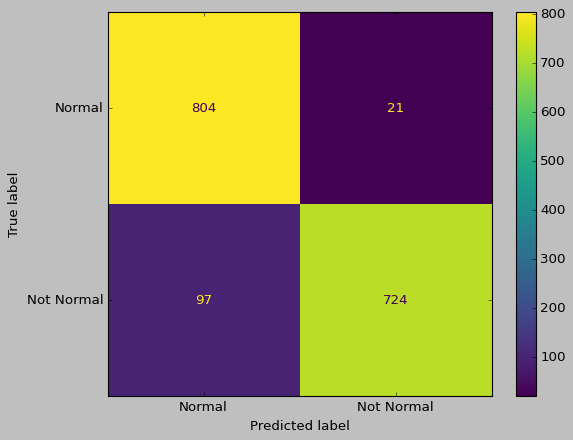

In [79]:
#for visualizing confusion matrix
style.use('classic')
cm = confusion_matrix(Y_test, logreg_predict, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()

## Model Deployment

def hate_speech_detection():
    import streamlit as st
    st.title("Hate Speech Detection")
    user = st.text_area("Enter any Tweet: ")
    if len(user) < 1:
        st.write("  ")
    else:
        sample = user
        data = cv.transform([sample]).toarray()
        a = clf.predict(data)
        st.title(a)
hate_speech_detection()

In [80]:
from joblib import dump, load
dump(logreg_hate, 'logreg_hate.joblib')
dump(logreg, 'ln.joblib')
#clf = load('filename.joblib')

['ln.joblib']

In [81]:
dump(vect, 'TfidfVectorizer.joblib')

['TfidfVectorizer.joblib']